In [1]:
from vdna import VDNAProcessor, EMD, load_vdna_from_files
import torch
import time
import matplotlib.pyplot as plt
import os
import json


c:\Users\sumal\anaconda3\envs\temp_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
xFormers not available
xFormers not available


In [2]:
vdna_proc = VDNAProcessor()
device = torch.device('cpu')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Configuration dictionary to manage paths
config = {
    "cityscapes_base_path": "dataset/Cityscapes/leftImg8bit/train",
    "kitti_360_base_path": "dataset/KITTI-360/data_2d_raw",
    "vdna_cityscapes_path": "output/vdna_cityscapes",
    "vdna_kitti_360_path": "output/vdna_kitti_360",
    "results_json_path": "output/results.json"
}

# Ensure paths exist
#for key, path in config.items():
    #if not os.path.exists(path):
        #raise FileNotFoundError(f"Path for {key} does not exist: {path}")

# Get all city directories at the same level as aachen, bochum, etc.
cityscapes_base_path = config["cityscapes_base_path"]
city_dirs = [os.path.join(cityscapes_base_path, city) for city in os.listdir(cityscapes_base_path) if os.path.isdir(os.path.join(cityscapes_base_path, city))]

# Collect all image paths from all city directories
all_image_paths = []
for city in city_dirs:
    for root, _, files in os.walk(city):
        for file in files:
            if file.endswith(".png"):  # Assuming images are in PNG format
                all_image_paths.append(os.path.join(root, file))

# Process all images collectively
vdna_cityscapes = vdna_proc.make_vdna(source=all_image_paths, device=device, num_workers=0, feat_extractor_name="dinov2_small_224")

# Ensure output directory exists
vdna_cityscapes_path = config["vdna_cityscapes_path"]
os.makedirs(os.path.dirname(vdna_cityscapes_path), exist_ok=True)

# Save the results
vdna_cityscapes.save(vdna_cityscapes_path)

results = []

Found 2975 images in the provided source
Using 2975 images


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:13<10:29, 13.69s/it]


KeyboardInterrupt: 

In [34]:
vdna_proc = VDNAProcessor()
device = torch.device('cpu')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

import warnings
import sys
from contextlib import contextmanager

config = {
    "cityscapes_base_path": "dataset/Cityscapes/leftImg8bit/train",
    "kitti_360_base_path": "dataset/KITTI-360/data_2d_raw",
    "vdna_cityscapes_path": "output/vdna_cityscapes",
    "vdna_kitti_360_path": "output/vdna_kitti_360",
    "results_json_path": "output/results.json",
    "log_file_path": "output/process.log"
}

# Context manager to redirect stdout and stderr
@contextmanager
def redirect_output(log_file_path):
    with open(log_file_path, 'a') as log_file:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = log_file
        sys.stderr = log_file
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Suppress warnings
warnings.filterwarnings("ignore")


kitti_360_base_path = config["kitti_360_base_path"]
vdna_cityscapes_path = config["vdna_cityscapes_path"]
vdna_kitti_360_path = config["vdna_kitti_360_path"]
vdna_cityscapes = load_vdna_from_files(vdna_cityscapes_path)

image_count = 0  # Counter for processed images since last save
# Redirect output to log file
count = 0
for root, _, files in os.walk(kitti_360_base_path):
     if 'image_00\data_rect' in root:
        count = count + 1
        if count == 10:
            vdna_kitti = vdna_proc.make_vdna(source=root, device=device, num_workers=0, feat_extractor_name="dinov2_small_224")
            vdna_kitti.save(vdna_kitti_360_path)

In [33]:

load_vdna1 = load_vdna_from_files(vdna_cityscapes_path)
load_vdna2 = load_vdna_from_files(vdna_kitti_360_path)
emd = EMD(load_vdna1, load_vdna2)
print(emd)

tensor(7.0647, dtype=torch.float64)


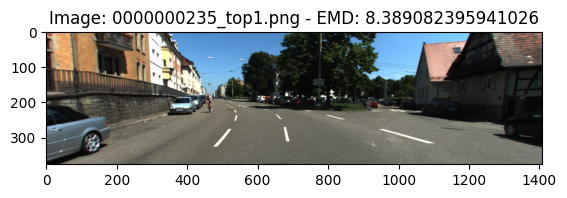

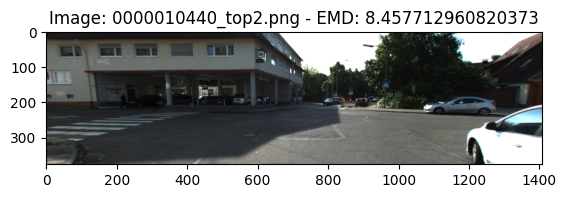

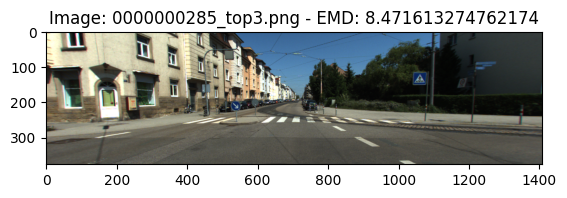

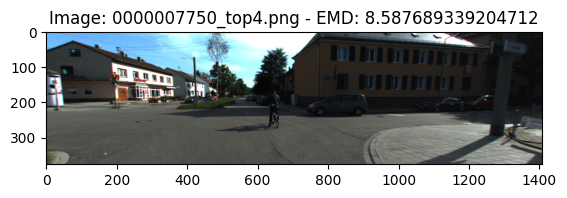

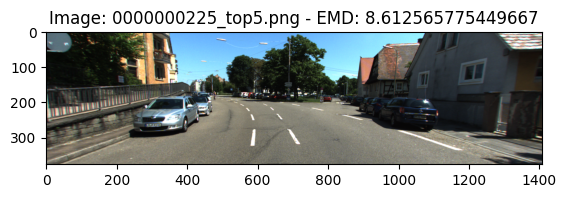

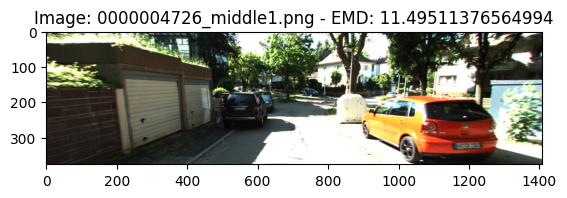

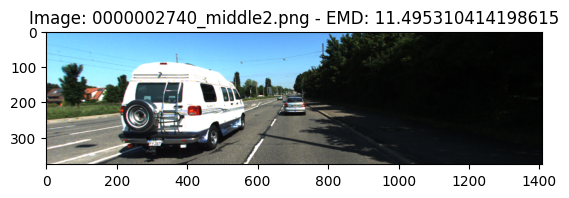

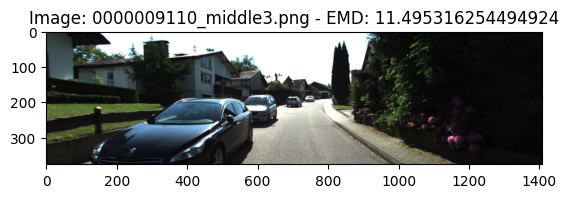

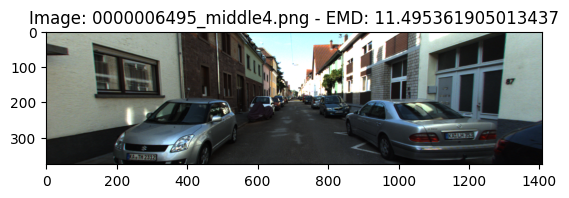

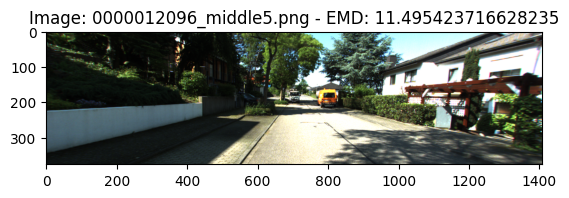

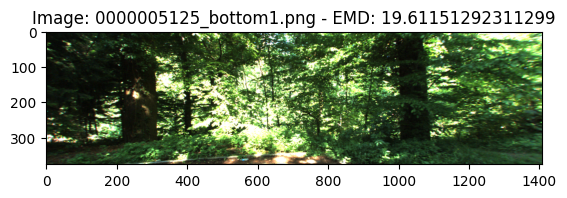

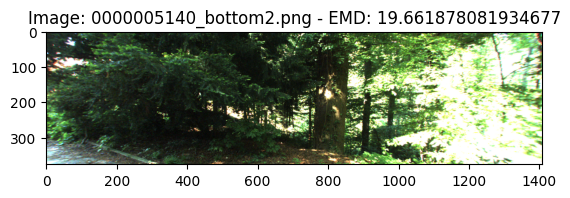

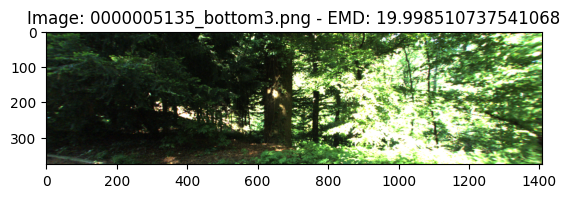

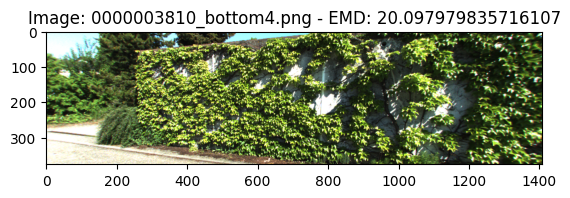

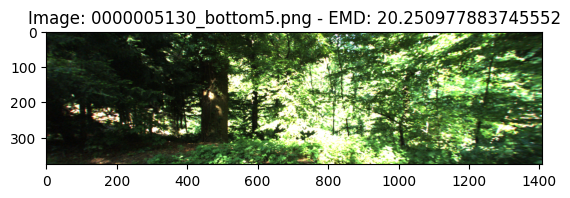

In [57]:
import os
import json
import shutil
import matplotlib.pyplot as plt

config = {
    "cityscapes_base_path": "dataset/Cityscapes/leftImg8bit/train",
    "kitti_360_base_path": "dataset/KITTI-360/data_2d_raw",
    "vdna_cityscapes_path": "output/vdna_cityscapes",
    "vdna_kitti_360_path": "output/vdna_kitti_360",
    "results_json_path": "output/results.json",
    "ranked_images_path": "output/ranked_images"
}

# Load the results from the JSON file
results_json_path = config["results_json_path"]
with open(results_json_path, 'r') as json_file:
    results = json.load(json_file)

# Sort results by EMD value
results = sorted(results, key=lambda x: x['emd'])

# Calculate indices for top 5, middle 5, and bottom 5
n = len(results)
top_5 = results[:5]
middle_5_start = max((n // 2) - 2, 0)
middle_5 = results[middle_5_start:middle_5_start + 5]
bottom_5 = results[-5:]

# Ensure the output directory exists
ranked_images_path = config["ranked_images_path"]
os.makedirs(ranked_images_path, exist_ok=True)

# Function to copy and rename images
def copy_and_rename_images(images, category, ranked_images_path):
    for idx, image_data in enumerate(images, start=1):
        src_path = image_data['image']
        image_name = os.path.basename(src_path)
        name, ext = os.path.splitext(image_name)
        dest_path = os.path.join(ranked_images_path, f"{name}_{category}{idx}{ext}")

        # Copy the image to the new location with the new name
        shutil.copy(src_path, dest_path)

        # Display the image
        img = plt.imread(dest_path)
        plt.imshow(img)
        plt.title(f"Image: {os.path.basename(dest_path)} - EMD: {image_data['emd']}")
        plt.show()
        plt.close()

# Copy and rename the selected images for each category
copy_and_rename_images(top_5, "top", ranked_images_path)
copy_and_rename_images(middle_5, "middle", ranked_images_path)
copy_and_rename_images(bottom_5, "bottom", ranked_images_path)


dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0010_sync\image_00\data_rect\0000000235.png 8.389082395941026


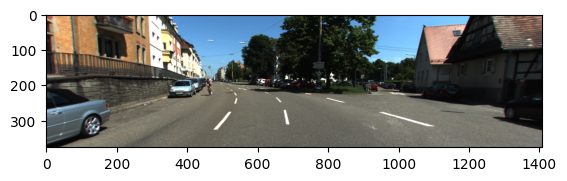

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000010440.png 8.457712960820373


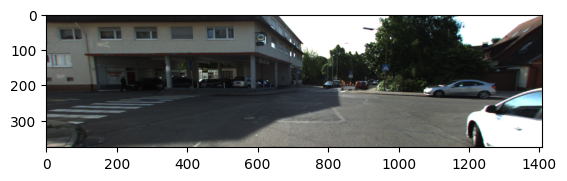

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0010_sync\image_00\data_rect\0000000285.png 8.471613274762174


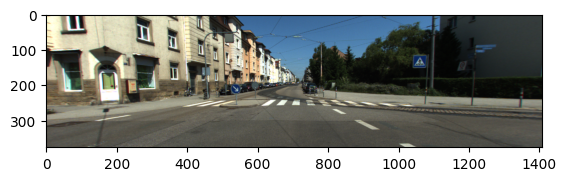

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007750.png 8.587689339204712


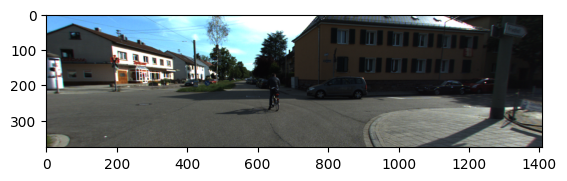

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0010_sync\image_00\data_rect\0000000225.png 8.612565775449667


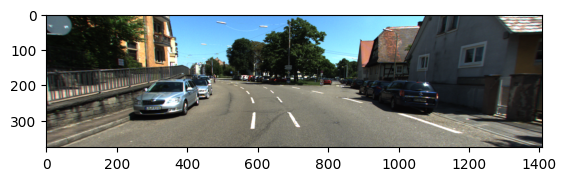

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0007_sync\image_00\data_rect\0000002740.png 11.495310414198615


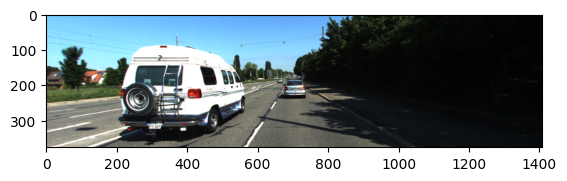

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0004_sync\image_00\data_rect\0000009110.png 11.495316254494924


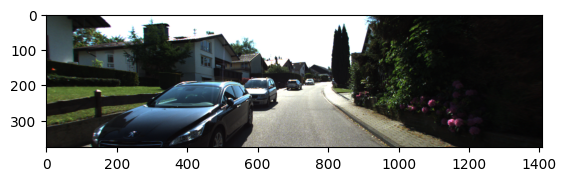

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000006495.png 11.495361905013437


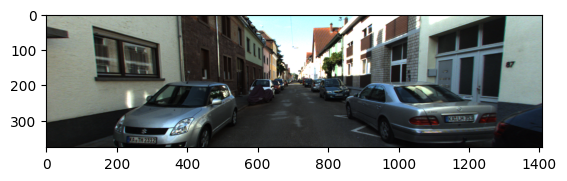

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0002_sync\image_00\data_rect\0000012096.png 11.495423716628235


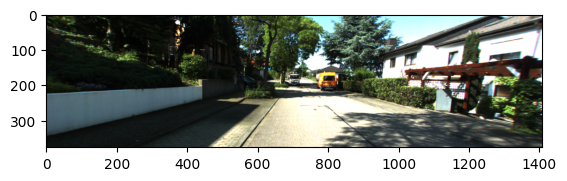

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0009_sync\image_00\data_rect\0000012200.png 11.495511220725954


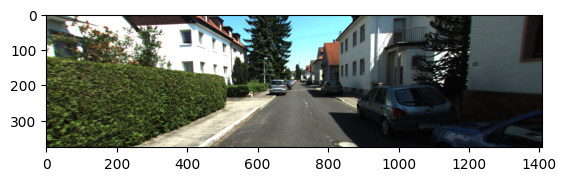

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0005_sync\image_00\data_rect\0000005125.png 19.61151292311299


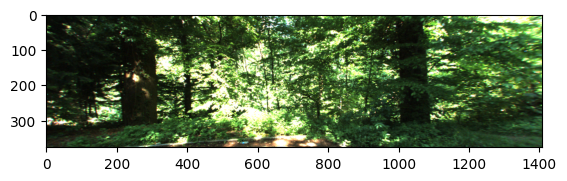

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0005_sync\image_00\data_rect\0000005140.png 19.661878081934677


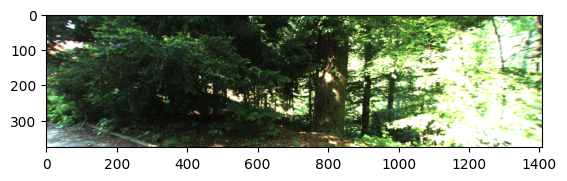

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0005_sync\image_00\data_rect\0000005135.png 19.998510737541068


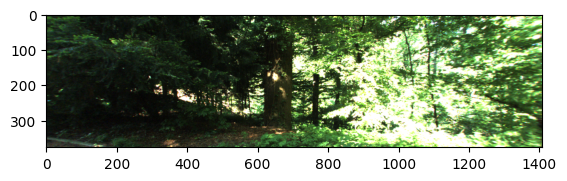

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0004_sync\image_00\data_rect\0000003810.png 20.097979835716107


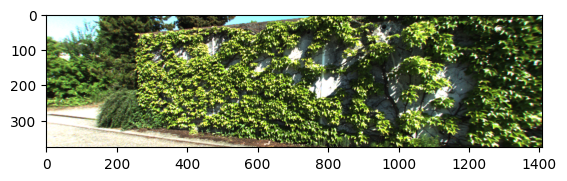

dataset/KITTI-360/data_2d_raw\2013_05_28_drive_0005_sync\image_00\data_rect\0000005130.png 20.250977883745552


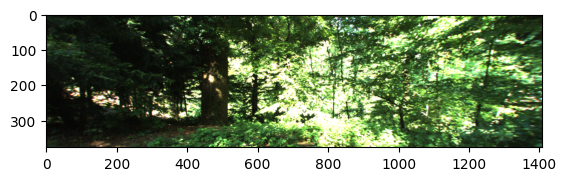

In [59]:
# Load the results from the JSON file
results_json_path = config["results_json_path"]
with open(results_json_path, 'r') as json_file:
    results = json.load(json_file)

# Sort results by EMD value
results = sorted(results, key=lambda x: x['emd'])

# Calculate indices for top 2, middle 2, and bottom 2
n = len(results)
top_5 = results[:5]
middle_5_start = max((n // 2) - 1, 0)
middle_5 = results[middle_5_start:middle_5_start + 5]
bottom_5 = results[-5:]

# Combine the selected images
selected_images = top_5 + middle_5 + bottom_5

# Display the selected images
for i in selected_images:
    print(i['image'], i['emd'])
    img = plt.imread(i['image'])  # Directly using the path from the JSON
    plt.imshow(img)
    # plt.title(f"Image: {i['image']} - EMD: {i['emd']}")
    plt.show()
    plt.close()


In [58]:
import os
from PIL import Image, ImageDraw, ImageFont

# Configuration
output_file = "output/ranked_images/collage_a4.png"
a4_width, a4_height = 2480, 3508  # A4 size at 300 DPI
grid_cols, grid_rows_per_block = 2, 1  # 2 images per block, 2 row per block
image_dir = "output/ranked_images/"  # Directory containing your images
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith(('.png', '.jpg', '.jpeg'))]

# Separate images into top, middle, and bottom blocks
top_images = [file for file in image_files if "top" in os.path.basename(file)]
middle_images = [file for file in image_files if "middle" in os.path.basename(file)]
bottom_images = [file for file in image_files if "bottom" in os.path.basename(file)]
cityscape_images = [file for file in image_files if not any(substring in os.path.basename(file) for substring in ["top", "middle", "bottom"])]


# Sort images by their indices
cityscape_images.sort()
top_images.sort()
middle_images.sort()
bottom_images.sort()

# Combine all images into one list in the correct order
selected_images = top_images + middle_images + bottom_images

# Ensure the output directory exists
ranked_images_path = os.path.dirname(output_file)
os.makedirs(ranked_images_path, exist_ok=True)

# Calculate the size of each image in the grid
block_height = a4_height // 4
#img_width = a4_width // grid_cols
#img_height = block_height // grid_rows_per_block

img_width = 1000
img_height = 400

# Create a blank A4 image
collage = Image.new('RGB', (a4_width, a4_height), (255, 255, 255))
draw = ImageDraw.Draw(collage)

# Font configuration for labels
try:
    font = ImageFont.truetype("arial.ttf", 40)
except IOError:
    font = ImageFont.load_default()

# Labels and their positions
labels = ["Cityscape", "Top-4", "Middle-4", "Bottom-4"]
label_positions = [(50, 20), (50, block_height), (50, 2 * block_height), (50, 3 * block_height)]

# Function to copy, resize, and paste images in the grid
def paste_images(images, start_y, label):
    for idx, image_file in enumerate(images):
        img = Image.open(image_file)
        img.thumbnail((img_width, img_height), Image.LANCZOS)

        # Calculate position
        row = idx // grid_cols
        col = idx % grid_cols
        x = col * img_width + 250
        y = start_y + row * img_height + 50

        # Calculate centering position
        offset_x = (img_width - img.width) // 2
        offset_y = (img_height - img.height) // 2

        collage.paste(img, (x + offset_x, y + offset_y))
    
    # Add label
    label_x, label_y = label_positions[label]
    draw.text((label_x, label_y), labels[label], fill="black", font=font)

# Paste images for each block
paste_images(cityscape_images, 10, 0)
paste_images(top_images, 15 + block_height, 1)
paste_images(middle_images, 20 + (2 * block_height), 2)
paste_images(bottom_images, 25 + (3 * block_height), 3)

# Save the collage
collage.save(output_file)
print(f"Collage saved to {output_file}")


Collage saved to output/ranked_images/collage_a4.png


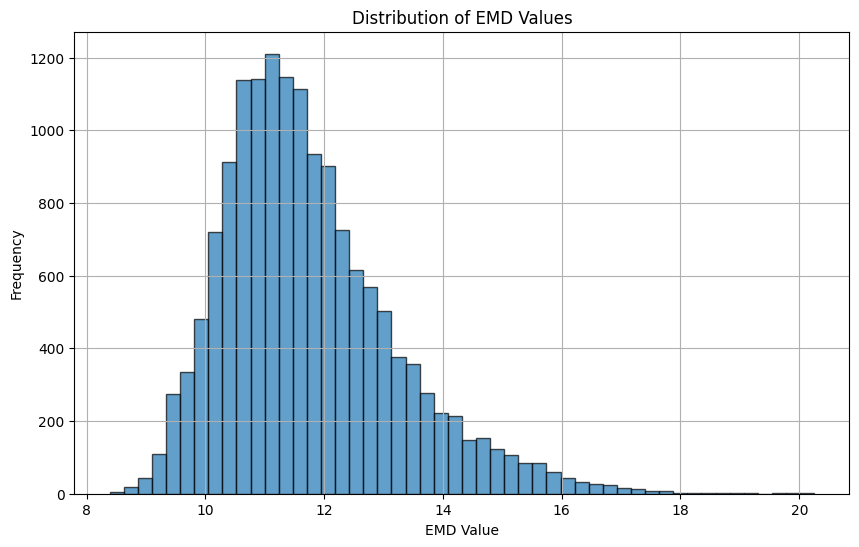

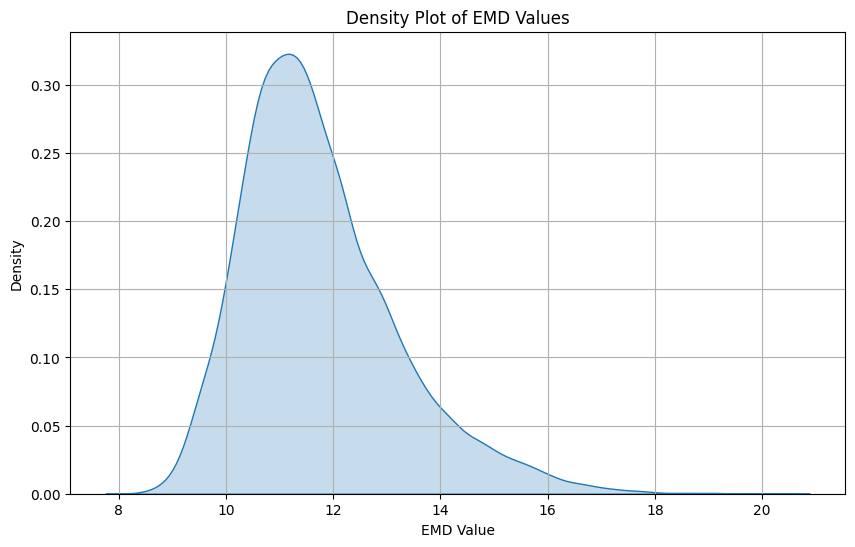

In [71]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the JSON file
results_json_path = config["results_json_path"]
with open(results_json_path, 'r') as json_file:
    results = json.load(json_file)

# Sort results by EMD value
results = sorted(results, key=lambda x: x['emd'])

# Extract EMD values
emd_values = [item['emd'] for item in results]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(emd_values, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of EMD Values')
plt.xlabel('EMD Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.kdeplot(emd_values, shade=True)
plt.title('Density Plot of EMD Values')
plt.xlabel('EMD Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [72]:
import json
import numpy as np

# Load the results from the JSON file
results_json_path = config["results_json_path"]
with open(results_json_path, 'r') as json_file:
    results = json.load(json_file)

# Sort results by EMD value
results = sorted(results, key=lambda x: x['emd'])

# Number of images to select
total_images = 1000

# Number of bins for uniform distribution
num_bins = 100

# Bin the EMD values
emd_values = [item['emd'] for item in results]
bins = np.linspace(min(emd_values), max(emd_values), num_bins + 1)
digitized = np.digitize(emd_values, bins)

# Select equal number of images from each bin
selected_results = []
images_per_bin = total_images // num_bins

for bin_idx in range(1, num_bins + 1):
    bin_images = [results[i] for i in range(len(results)) if digitized[i] == bin_idx]
    if len(bin_images) >= images_per_bin:
        selected_results.extend(bin_images[:images_per_bin])
    else:
        selected_results.extend(bin_images)

# Ensure we have exactly 3000 images (due to rounding, might be slightly more or less)
selected_results = selected_results[:total_images]

# Save the selected results to a new JSON file
selected_results_json_path = "output/uniform_results.json"
os.makedirs(os.path.dirname(selected_results_json_path), exist_ok=True)
with open(selected_results_json_path, 'w') as json_file:
    json.dump(selected_results, json_file, indent=4)

print(f"Uniformly distributed images saved to {selected_results_json_path}")


Uniformly distributed images saved to output/uniform_results.json


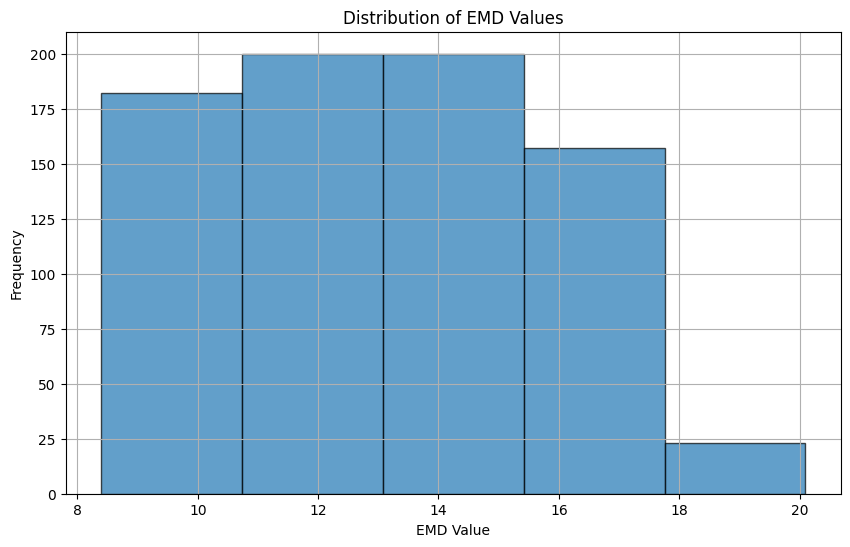

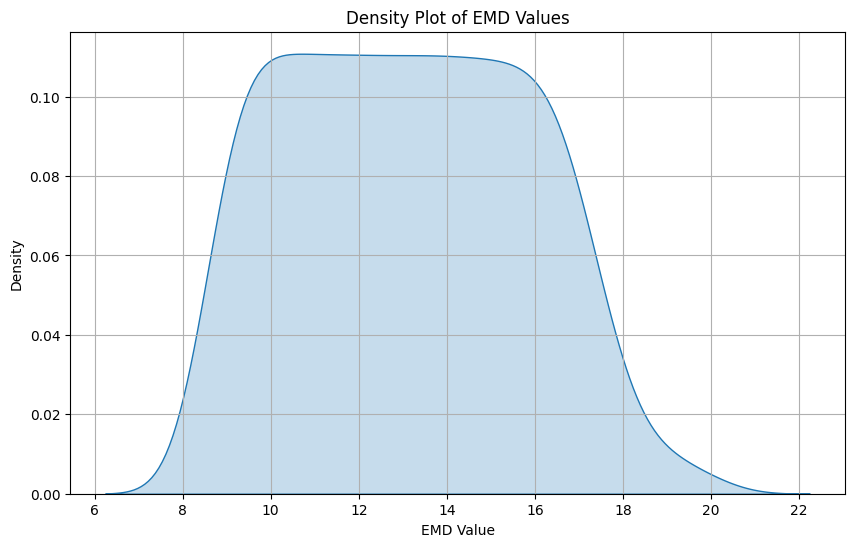

In [73]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the JSON file
results_json_path = "output/uniform_results.json"
with open(results_json_path, 'r') as json_file:
    results = json.load(json_file)

# Sort results by EMD value
results = sorted(results, key=lambda x: x['emd'])

# Extract EMD values
emd_values = [item['emd'] for item in results]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(emd_values, bins=5, edgecolor='k', alpha=0.7)
plt.title('Distribution of EMD Values')
plt.xlabel('EMD Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.kdeplot(emd_values, shade=True)
plt.title('Density Plot of EMD Values')
plt.xlabel('EMD Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()


Found 2304 images in the provided source
Using 2304 images


  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [02:02<00:00,  3.40s/it]


Found 174 images in the provided source
Using 174 images


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:26<00:00,  8.87s/it]


Found 96 images in the provided source
Using 96 images


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:14<00:00,  7.45s/it]


Found 316 images in the provided source
Using 316 images


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:49<00:00,  9.92s/it]


Found 154 images in the provided source
Using 154 images


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:26<00:00,  8.74s/it]


Found 85 images in the provided source
Using 85 images


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:15<00:00,  7.76s/it]


Found 221 images in the provided source
Using 221 images


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:36<00:00,  9.19s/it]


Found 109 images in the provided source
Using 109 images


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:19<00:00,  9.58s/it]


Found 248 images in the provided source
Using 248 images


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:42<00:00, 10.53s/it]


Found 196 images in the provided source
Using 196 images


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:32<00:00,  8.15s/it]


Found 119 images in the provided source
Using 119 images


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:19<00:00,  9.64s/it]


Found 99 images in the provided source
Using 99 images


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:16<00:00,  8.05s/it]


Found 94 images in the provided source
Using 94 images


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:15<00:00,  7.57s/it]


Found 365 images in the provided source
Using 365 images


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:59<00:00,  9.94s/it]


Found 196 images in the provided source
Using 196 images


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:32<00:00,  8.06s/it]


Found 144 images in the provided source
Using 144 images


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


Found 95 images in the provided source
Using 95 images


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:15<00:00,  7.73s/it]


Found 142 images in the provided source
Using 142 images


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:22<00:00,  7.62s/it]


Found 122 images in the provided source
Using 122 images


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:19<00:00,  9.65s/it]


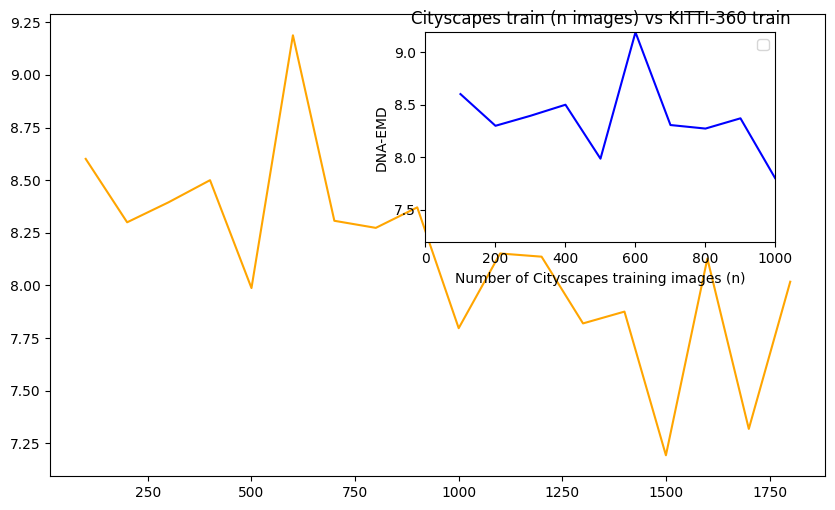

In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from vdna import VDNAProcessor, load_vdna_from_files, EMD

device = torch.device('cpu')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

def create_vdna(dataset_path, save_path):
    vdna_proc = VDNAProcessor()
    vdna = vdna_proc.make_vdna(
        source=dataset_path, 
        num_workers=0,
        feat_extractor_name="dinov2_small_224"
    )
    vdna.save(save_path)
    return vdna

def calculate_emd(vdna1_path, vdna2_path):
    vdna1 = load_vdna_from_files(vdna1_path)
    vdna2 = load_vdna_from_files(vdna2_path)
    return EMD(vdna1, vdna2)

# Paths to datasets
cityscapes_base = "dataset/Cityscapes/leftImg8bit/train"
kitti_360 = "dataset/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect"

# Paths to save VDNAs
cityscapes_output_template = "output/vdna_cityscapes_{}"
kitti_360_output = "output/kitti_360_v1"

# Create and save VDNAs for KITTI-360
create_vdna(kitti_360, kitti_360_output)

# List of subfolders in the Cityscapes training dataset
cityscapes_subfolders = [os.path.join(cityscapes_base, subfolder) for subfolder in os.listdir(cityscapes_base)]

# Calculate DNA-EMD for each Cityscapes subset compared to KITTI-360
dna_emd_cityscapes_kitti360 = []
for i, subfolder in enumerate(cityscapes_subfolders):
    cityscapes_vdna_path = cityscapes_output_template.format(i)
    create_vdna(subfolder, cityscapes_vdna_path)
    dna_emd_cityscapes_kitti360.append(calculate_emd(cityscapes_vdna_path, kitti_360_output))

# Number of samples for the x-axis (assuming each subfolder represents a different number of samples)
num_samples_list = np.arange(100, 100 * len(cityscapes_subfolders) + 1, 100)

# Plotting the results
plt.figure(figsize=(10, 6))

# Main plot
plt.plot(num_samples_list, dna_emd_cityscapes_kitti360, label='Cityscapes train vs KITTI-360 train', color='orange')

# Inset plot
ax_inset = plt.axes([0.5, 0.5, 0.35, 0.35])
ax_inset.plot(num_samples_list, dna_emd_cityscapes_kitti360, color='blue')
ax_inset.set_xlim([0, 1000])
ax_inset.set_ylim([min(dna_emd_cityscapes_kitti360), max(dna_emd_cityscapes_kitti360)])
# ax_inset.set_title("Inset: First 1000 samples")

plt.xlabel('Number of Cityscapes training images (n)')
plt.ylabel('DNA-EMD')
plt.title('Cityscapes train (n images) vs KITTI-360 train')
plt.legend()

plt.show()


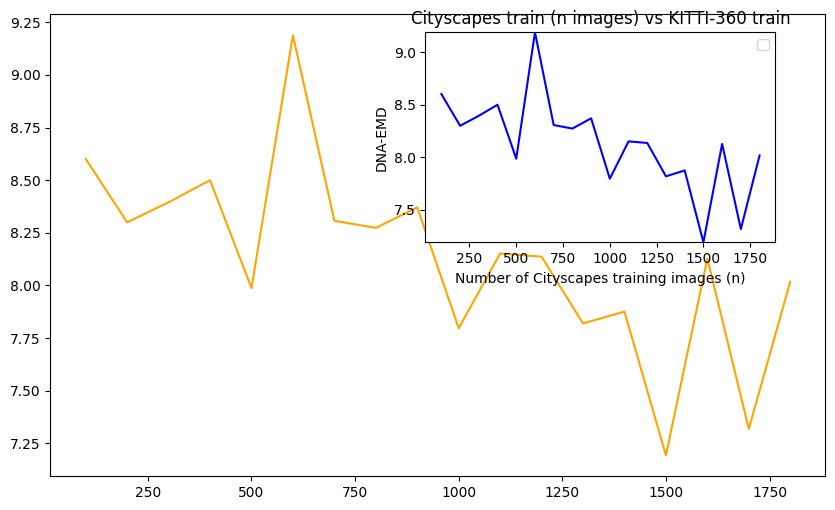

In [40]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Main plot
plt.plot(num_samples_list, dna_emd_cityscapes_kitti360, label='Cityscapes train vs KITTI-360 train', color='orange')

# Inset plot
ax_inset = plt.axes([0.5, 0.5, 0.35, 0.35])
ax_inset.plot(num_samples_list, dna_emd_cityscapes_kitti360, color='blue')
# ax_inset.set_xlim([0, 1000])
ax_inset.set_ylim([min(dna_emd_cityscapes_kitti360), max(dna_emd_cityscapes_kitti360)])
# ax_inset.set_title("Inset: First 1000 samples")

plt.xlabel('Number of Cityscapes training images (n)')
plt.ylabel('DNA-EMD')
plt.title('Cityscapes train (n images) vs KITTI-360 train')
plt.legend()

plt.show()
